In [1]:
import pickle
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Data quality / cleaning

In [2]:
# Business id's & titles
with open('nd_state_ss/nd_state_ss/biz_title.p', 'rb') as f:
    biz_title_in = pd.DataFrame.from_dict(pickle.load(f),
                                          orient='index')
    #Data types
    biz_title_in.index = biz_title_in.index.astype(int)
    biz_title_in.rename(columns={0:"title"},inplace=True)

In [3]:
# In the web UI the first 19 also do not start with X
biz_title_in.head(25)

,title
103327,AKITA DRILLING USA CORP.
103679,AKITA EQUIPMENT CORP.
100012,"AMERICAN ELECTRIC, INC. (dba XYZ ELECTRIC, INC.)"
144321,"ATOS HEALTHCARE SERVICES, LLC"
144320,"ATOS IT OUTSOURCING SERVICES, LLC"
165394,"COMCAST BROADBAND SECURITY, LLC (dba XFINITY H..."
97654,"CONDUENT BUSINESS SERVICES, LLC"
154781,"CONDUENT CARD SERVICES, LLC"
48426,"CONDUENT GOVERNMENT SYSTEMS, LLC"
22620,CONDUENT HEALTHCARE PROVIDER CONSULTING SOLUTI...


In [4]:
# Drop the non X titles
biz_title = biz_title_in.iloc[19:]

In [5]:
biz_title.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 125881 to 162412
Data columns (total 1 columns):
title    172 non-null object
dtypes: object(1)
memory usage: 2.7+ KB


In [17]:
# read in biz_info
# id, mailing address, owner, agent for each business
biz_info_file ='nd_state_ss/nd_state_ss/biz_info.jl'
biz_info = pd.read_json(biz_info_file,
             orient='values',
             lines=True,)
biz_info.astype({'id':int}, inplace=True) # id column to int
biz_info.set_index('id', inplace=True) # id to index

In [7]:
biz_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 4 columns):
id          191 non-null int64
maddress    188 non-null object
owner       43 non-null object
agent       143 non-null object
dtypes: int64(1), object(3)
memory usage: 6.1+ KB


## Data issues
for future investigation

In [18]:
# Missing mailing address
biz_info[biz_info.maddress.isnull()]

,maddress,owner,agent
id,,,
195444,None,"XTRALIGHT MANUFACTURING, LTD.",None
196642,None,"XPRESSDOCS PARTNERS, LTD.",None
279897,None,SHOES 'N' SUCH LLP,None


In [19]:
# Missing owner or agent
biz_info[biz_info.owner.isnull() & biz_info.agent.isnull()]

,maddress,owner,agent
id,,,
231461,"401 6TH ST SE\nDEVILS LAKE, ND 58301-3629",None,None
257509,"2539 HUNTINGTON PARK DR\nGRAND FORKS, ND 58201...",None,None
259434,"121 3RD AVE E\nWEST FARGO, ND 58078-1820",None,None
266292,"7021 ENDICOTT DR\nBISMARCK, ND 58503-6900",None,None
261912,"1705 1ST AVE SE\nMINOT, ND 58701-4107",None,None


In [20]:
# Drop Missing owner or agent
biz_info.dropna(how='all',
                subset=['owner','agent'],
                inplace=True)

In [21]:
# Join titles with other info
biz = biz_title.join(biz_info)
biz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 125881 to 162412
Data columns (total 4 columns):
title       172 non-null object
maddress    164 non-null object
owner       43 non-null object
agent       124 non-null object
dtypes: object(4)
memory usage: 11.7+ KB


In [22]:
biz.head(3)

,title,maddress,owner,agent
125881,"X 1 BUILDERS , LLC","1940 S BROADWAY\nSTE 173\nMINOT, ND 58701-6508",None,"JEFF BARLOW\n1940 S BROADWAY STE 173\nMINOT, ..."
111048,"X BAR BAR ENTERPRISES, INC.","1771 W 1500 S\nVERNAL, UT 84078-4527",None,"NATIONAL REGISTERED AGENTS, INC.\n120 W SWEET ..."
244002,X ELECTRIC,"311 RAILROAD ST W\nNORWOOD, MN 55368-9774","XTREME ELECTRICAL SERVICES, INC.",None


## Network visualization
of companies, registered agents, and owners

In [23]:
# Create a graph
G = nx.Graph()

# For each row in the biz data set create a
#  company node and nodes for the owner and/or agent of that company
for b in biz.itertuples():
    
    #print("company node")
    G.add_node(b.title)
    
    if b.owner:
        #print("\t owner node:", b.owner)
        G.add_node(b.owner)
        G.add_edge(b.title, b.owner)

    if b.agent:
        #print("\t agent node:", b.agent)
        G.add_node(b.agent)
        G.add_edge(b.title, b.agent)

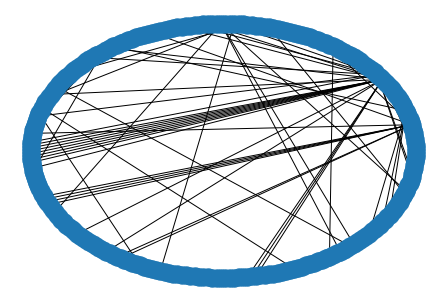

In [24]:
# Draw shell graph    
nx.draw_shell(G, 
              with_labels=False,
              font_weight='bold')